### 1_np.astype(np.int32
### 2_reshape from (160,120,3) to (120,160,3)
### 3_layers.Normalization
### 4_classification
### 5_ use only rotational velocities those are less than one
### 6_ using history of the robot's trajectory

In [1]:
cd G:\project\fifth_try\data

G:\project\fifth_try\data


In [2]:
ls

 Volume in drive G is New Volume
 Volume Serial Number is BCD7-8E47

 Directory of G:\project\fifth_try\data

07/29/2023  04:49 PM    <DIR>          .
07/30/2023  12:17 PM    <DIR>          ..
07/28/2023  11:14 AM         1,244,952 current_pose_per_episode.npy
07/28/2023  01:25 PM             4,216 episode_length.npy
07/28/2023  11:14 AM    10,243,123,328 image_data_per_episode.npy
07/28/2023  11:14 AM         1,067,120 velocity_data_per_episode.npy
07/28/2023  07:08 PM           533,360 W_Current_pose.npy
07/28/2023  07:08 PM             4,128 W_Episode.npy
07/28/2023  07:08 PM    10,238,054,528 W_Image_data_per_episode.npy
07/28/2023  07:08 PM           355,616 W_R_T_data.npy
07/28/2023  07:22 PM            54,512 W_teest_Current_pose.npy
07/28/2023  07:22 PM               528 W_test_Episode.npy
07/28/2023  07:22 PM     1,044,172,928 W_test_Image_data_per_episode.npy
07/28/2023  07:22 PM            36,384 W_test_R_T_data.npy
07/28/2023  07:22 PM           108,896 W_test_Velocity.npy


In [3]:
import numpy as np
image = np.load("W_Image_data_per_episode.npy",mmap_mode='c')
episode_length = np.load("W_Episode.npy",mmap_mode='c')
velocity = np.load("W_Velocity.npy",mmap_mode='c')
r_theta_data = np.load("W_R_T_data.npy",mmap_mode='c')


test_image = np.load("W_test_Image_data_per_episode.npy",mmap_mode='c')
test_episode_length = np.load("W_test_Episode.npy",mmap_mode='c')
test_velocity = np.load("W_test_Velocity.npy",mmap_mode='c')
test_r_theta_data = np.load("W_test_R_T_data.npy",mmap_mode='c')

In [4]:
episode_length.shape

(500,)

### astype int32

In [5]:
image = image.astype(np.int32)
test_image = test_image.astype(np.int32)

### Reshape

In [6]:
image = np.reshape(image,[22218,120,160,3])
test_image = np.reshape(test_image,[2266,120,160,3])

In [7]:
image_array = image[18345]

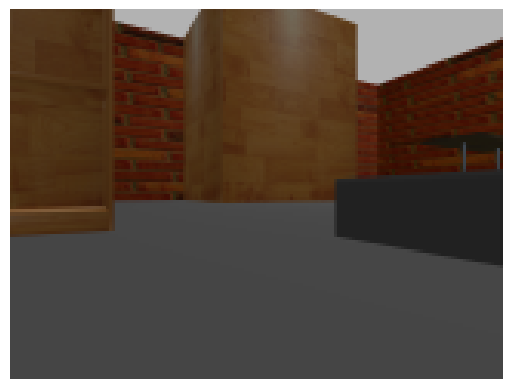

In [8]:
import matplotlib.pyplot as plt
plt.imshow(image_array)
plt.axis('off')  # Optional: turn off axis ticks and labels
plt.show()

### rounding velocity

In [9]:
velocity = np.around(velocity,decimals=1)
#r_theta_data = np.around(r_theta_data,decimals=2)


test_velocity = np.around(test_velocity,decimals=1)
#test_r_theta_data = np.around(test_r_theta_data,decimals=2)

In [10]:
greater_than_one = []
for i in range(len(velocity)):
    if abs(velocity[:,1,2][i])>=1.0:
        greater_than_one.append(i)

greater_than_one_test = []
for i in range(len(test_velocity)):
    if abs(test_velocity[:,1,2][i])>=1.0:
        greater_than_one_test.append(i)

#### delete data

In [11]:
velocity = np.delete(velocity,greater_than_one,axis=0)
test_velocity = np.delete(test_velocity,greater_than_one_test,axis=0)


image = np.delete(image,greater_than_one,axis=0)
test_image = np.delete(test_image,greater_than_one_test,axis=0)

r_theta_data = np.delete(r_theta_data,greater_than_one,axis=0)
test_r_theta_data = np.delete(test_r_theta_data,greater_than_one_test,axis=0)

# import required libraries

In [12]:
from tensorflow.keras.layers import Activation , concatenate
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#pip install tensorflow-addons
import tensorflow_addons as tfa

G:\Anaconda\envs\tensorflow\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Prepare The Data

In [13]:
input_shape = (120, 160, 3)
#linear ==> 7
#angular ==> 34
num_classes_linear = 7
num_classes_angular = 11
x_train = image
y_train = velocity

x_test = test_image
y_test = test_velocity
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")


x_train shape: (22153, 120, 160, 3) - y_train shape: (22153, 2, 3)


# configuring the hyperparameters

In [14]:
learning_rate = 0.01 # used to be 0.01
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
image_size = 256  # We'll resize input images to this size
patch_size = 64  # Size of the patches to be extract from the input images  ==> used to be 32
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 2
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

# data augmentation

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        #layers.RandomFlip("horizontal"),
        #layers.RandomRotation(factor=0.02),
        #layers.RandomZoom(
        #    height_factor=0.2, width_factor=0.2
        #),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

# Implement multilayer perceptron (MLP)



#### using multiple Dense layer

In [16]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Implement patch creation as a layer

In [17]:

#Goal MLP
#Goal is sth like np.array([[1,2]])
'''
Goal = mlp(goal,[16,64,192]) #shape=(1, 192)
tf.reshape(Goal,[6,6,3])
'''
#use it alongside image patches

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        #print("batch_size ==> ",batch_size)
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        
        #3072/3=1024
        #sqrt(1024) = 32
        #32*8=256
        #print('$$patch_size$$ ',patches.shape) #(None, 8, 8, 3072)
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        #print('$$patch_size2$$ ',patches.shape)
        return patches

# Implement the patch encoding layer

##### --> linearly transform a patch by projecting it into a vector of size projection_dim. 
##### --> it adds a learnable position embedding to the projected vector

In [33]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim) #Linear Projection Of Patch-Tockens
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        
        #input_dim ==> encoding number 0 to num_patches -1
        #output_dim ==> self explanatary -> turns every input to output_dim
        #input_length ==> the Maximum length of input sequence 
        '''
        input_dim=10 ==> each word in input
        output_dim=4
        input_length=2
        
        >> input_data = np.array([[1,2]])
        input ->(1, 2)
        output ->[[[ 0.04502351  0.00151128  0.01764284 -0.0089057 ]
                    [-0.04007018  0.02874336  0.02772436  0.00842067]]]
        '''

        
        
    def call(self, patch):

        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        
        return encoded

In [19]:
episode_length

memmap([   42.,    92.,   143.,   196.,   246.,   297.,   358.,   420.,
          483.,   533.,   587.,   656.,   717.,   768.,   819.,   878.,
          923.,   993.,  1045.,  1105.,  1152.,  1194.,  1243.,  1284.,
         1319.,  1364.,  1396.,  1434.,  1467.,  1510.,  1548.,  1586.,
         1631.,  1680.,  1719.,  1750.,  1812.,  1841.,  1884.,  1910.,
         1934.,  1955.,  1981.,  2010.,  2045.,  2070.,  2099.,  2127.,
         2156.,  2182.,  2222.,  2273.,  2323.,  2369.,  2432.,  2496.,
         2552.,  2632.,  2687.,  2758.,  2806.,  2854.,  2916.,  2962.,
         3012.,  3079.,  3132.,  3176.,  3221.,  3270.,  3321.,  3364.,
         3430.,  3458.,  3493.,  3527.,  3556.,  3592.,  3622.,  3654.,
         3685.,  3720.,  3751.,  3786.,  3819.,  3847.,  3885.,  3917.,
         3945.,  3976.,  4020.,  4061.,  4097.,  4126.,  4161.,  4192.,
         4224.,  4262.,  4294.,  4330.,  4372.,  4425.,  4493.,  4554.,
         4614.,  4665.,  4736.,  4807.,  4858.,  4928.,  4991., 

# Incremantal Inputs for Vit

In [31]:
def create_vit_classifier():
    image_input = layers.Input(shape=input_shape)
    relative_distance_input = layers.Input(shape=(2,))
    prev_images_input = layers.Input(shape=(None,) + input_shape)
    prev_relative_distances_input = layers.Input(shape=(None, 2))

    # Augment data.
    augmented = data_augmentation(image_input)

    # Create patches.
    patches = Patches(patch_size)(augmented)

    # Add Goal to Patches
    Goal = mlp(relative_distance_input, [32, 512, 3072, 12288], dropout_rate=0.05)
    Goal = tf.expand_dims(Goal, axis=1)

    # Concatenate Goal with patches
    print(f'Goal ==> {Goal.shape}')
    print(f'Patches ==> {patches.shape}')
    patches = tf.keras.layers.Concatenate(axis=1)([Goal, patches])

    # Encode patches.
    encoded_patches = PatchEncoder(num_patches+1, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.2)(representation)

    #1
    # Concatenate previous representations with masking
    #prev_representations = layers.Masking()(prev_images_input)
    #prev_representations = layers.Concatenate(axis=-1)([prev_representations, prev_relative_distances_input])

    #2

    #prev_representations = layers.TimeDistributed(layers.Masking())(prev_images_input)
    #prev_representations = layers.Concatenate(axis=-1)([prev_representations, prev_relative_distances_input])


    #3
    print("@@@ before prev_representation@@@")
    #prev_relative_distances_rep = tf.expand_dims(prev_relative_distances_input, axis=-2)
    #prev_relative_distances_rep = tf.expand_dims(prev_relative_distances_rep, axis=-2)
    #prev_representations = layers.Concatenate(1)([prev_images_input, prev_relative_distances_rep])
    print("^^^^^^ after prev_representation ^^^^^^")

    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.1)
    
    # Concatenate features with previous representations
    features = layers.RepeatVector(tf.shape(prev_representations)[1])(features)
    features = layers.Concatenate(axis=-1)([prev_representations, features])
    
    logits_linear = layers.Dense(num_classes_linear, activation='softmax', name='linear')(features)
    logits_angular = layers.Dense(num_classes_angular, activation='softmax', name='angular')(features)
    
    # Create the Keras model
    model = keras.Model(inputs=[image_input, relative_distance_input, prev_images_input, prev_relative_distances_input],
                        outputs=[logits_linear, logits_angular])
    
    return model


# Digitalize

In [21]:
print(f'linear ===> {np.unique(y_train[:, 0, 0])}')
print(f'angular ===> {np.unique(y_train[:, 1, 2])}')

linear ===> [-0.2 -0.1  0.   0.1  0.2  0.3]
angular ===> [-0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1 -0.   0.1  0.2  0.3  0.4
  0.5  0.6  0.7  0.8  0.9]


In [22]:

# Define velocity ranges and corresponding class labels
velocity_ranges_linear = [ -0.2, -0.1,  0. ,  0.1,  0.2,  0.3]
velocity_ranges_angular = [-0.9, -0.7, -0.5, -0.3, -0.1,  0. ,  0.1,
          0.3,  0.5,  0.7,  0.9]

num_classes_linear = len(velocity_ranges_linear) 
num_classes_angular = len(velocity_ranges_angular) 

# Convert continuous velocity values into categorical labels
y_train_categorical_linear = np.digitize(y_train[:, 0, 0], velocity_ranges_linear)
y_train_categorical_angular = np.digitize(y_train[:, 1, 2], velocity_ranges_angular)
y_test_categorical_linear = np.digitize(y_test[:, 0, 0], velocity_ranges_linear)
y_test_categorical_angular = np.digitize(y_test[:, 1, 2], velocity_ranges_angular)


In [23]:
y_train_categorical_linear-=1
y_train_categorical_angular-=1
y_test_categorical_linear-=1
y_test_categorical_angular-=1

# Compile The Model Using fit

In [24]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    losses = {
        "linear": keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        "angular": keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    }
    loss_weights = {
        "linear": 1.0,
        "angular": 4.0
    }
    metrics = {
        "linear": [
            keras.metrics.SparseCategoricalAccuracy(name="linear_accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="linear_top-5-accuracy")
        ],
        "angular": [
            keras.metrics.SparseCategoricalAccuracy(name="angular_accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="angular_top-5-accuracy")
        ]
    }

    model.compile(
        optimizer=optimizer,
        loss=losses,
        metrics=metrics
    )

    log_dir = ''
    checkpoint_filepath = log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = []
    prev_images = None
    prev_relative_distances = None

    for i in range(len(x_train)):
        current_image = x_train[i]
        current_relative_distance = r_theta_data[i]

        if prev_images is None:
            prev_images = current_image[np.newaxis, :]
            prev_relative_distances = current_relative_distance[np.newaxis, :]
        else:
            prev_images = np.concatenate([prev_images, current_image[np.newaxis, :]], axis=0)
            prev_relative_distances = np.concatenate([prev_relative_distances, current_relative_distance[np.newaxis, :]], axis=0)

        model.fit(
            x=[current_image[np.newaxis, :], current_relative_distance[np.newaxis, :], prev_images, prev_relative_distances],
            y=[y_train_categorical_linear[i][np.newaxis], y_train_categorical_angular[i][np.newaxis]],
            batch_size=batch_size,
            epochs=num_epochs,
            validation_data=(
                [x_test, test_r_theta_data, prev_images, prev_relative_distances],
                [y_test_categorical_linear, y_test_categorical_angular]
            ),
            callbacks=[checkpoint_callback],
            shuffle=False
        )

        model.load_weights(checkpoint_filepath)

        model.save('')

        history.append(model.history)

    return history

max_len = max(episode_length)
vit_classifier = create_vit_classifier(max_len)
history = run_experiment(vit_classifier)


TypeError: create_vit_classifier() takes 0 positional arguments but 1 was given

# Compile The Model Using fit_generator

In [24]:
def custom_generator(x_train, y_train_linear, y_train_angular, r_theta_data, episode_length):
    episode_start_index = 0

    for episode_len in episode_length.astype(int):
        episode_images = x_train[episode_start_index:episode_start_index + episode_len]
        episode_relative_distances = r_theta_data[episode_start_index:episode_start_index + episode_len]
        episode_labels_linear = y_train_linear[episode_start_index:episode_start_index + episode_len]
        episode_labels_angular = y_train_angular[episode_start_index:episode_start_index + episode_len]

        prev_images = None
        prev_relative_distances = None

        for i in range(episode_len):
            current_image = episode_images[i]
            current_relative_distance = episode_relative_distances[i]
            current_label_linear = episode_labels_linear[i]
            current_label_angular = episode_labels_angular[i]

            if prev_images is None:
                prev_images = current_image[np.newaxis, :]
                prev_relative_distances = current_relative_distance[np.newaxis, :]
            else:
                prev_images = np.concatenate([prev_images, current_image[np.newaxis, :]], axis=0)
                prev_relative_distances = np.concatenate([prev_relative_distances, current_relative_distance[np.newaxis, :]], axis=0)

            yield [current_image[np.newaxis, :], current_relative_distance[np.newaxis, :], prev_images, prev_relative_distances], [current_label_linear[np.newaxis], current_label_angular[np.newaxis]]

        episode_start_index += episode_len


In [32]:
def run_experiment(model, x_train, y_train_linear, y_train_angular, r_theta_data, episode_length):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    losses = {
        "linear": keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        "angular": keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    }

    loss_weights = {
        "linear": 1.0,
        "angular": 4.0
    }
    metrics = {
        "linear": [
            keras.metrics.SparseCategoricalAccuracy(name="linear_accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="linear_top-5-accuracy")
        ],
        "angular": [
            keras.metrics.SparseCategoricalAccuracy(name="angular_accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="angular_top-5-accuracy")
        ]
    }

    model.compile(
        optimizer=optimizer,
        loss=losses,
        metrics=metrics
    )

    log_dir = ''
    checkpoint_filepath = log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    generator = custom_generator(x_train, y_train_linear, y_train_angular, r_theta_data, episode_length)
    model.fit_generator(
        generator=generator,
        steps_per_epoch=len(episode_length),
        epochs=num_epochs,
        validation_data=(
            [x_test, test_r_theta_data, prev_images, prev_relative_distances],
            [y_test_categorical_linear, y_test_categorical_angular]
        ),
        callbacks=[checkpoint_callback],
        shuffle=False
    )

# Usage:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier, x_train, y_train_categorical_linear, y_train_categorical_angular, r_theta_data, episode_length)

Goal ==> (None, 1, 12288)
Patches ==> (None, None, 12288)
****  (None, 17, 64)
@@@ before prev_representation@@@


ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, None, 120, 160, 3), (None, None, 1, 1, 2)]

# Compile The Model Using train_on_batch

In [ ]:
for i in range(len(x_train)):
    current_image = x_train[i]
    current_relative_distance = r_theta_data[i]
    current_label_linear = y_train_categorical_linear[i]
    current_label_angular = y_train_categorical_angular[i]

    # Incrementally accumulate previous data
    if prev_images is None:
        prev_images = current_image[np.newaxis, :]
        prev_relative_distances = current_relative_distance[np.newaxis, :]
    else:
        prev_images = np.concatenate([prev_images, current_image[np.newaxis, :]], axis=0)
        prev_relative_distances = np.concatenate([prev_relative_distances, current_relative_distance[np.newaxis, :]], axis=0)

    model.train_on_batch(
        x=[current_image[np.newaxis, :], current_relative_distance[np.newaxis, :], prev_images, prev_relative_distances],
        y=[current_label_linear[np.newaxis], current_label_angular[np.newaxis]]
    )
